## BERT Model <a class="anchor"  id="chapter7"></a> 

### Building BERT Model Architecture  <a class="anchor"  id="section_7_1"></a>


For my BERT model, I will use the pre-trained model BertForSequenceClassification. The BertForSequenceClassification model comes default with one output layer to predict the sequence classification task, but I have added additional layers on top of it to optimize its performance.

The 'bert-base-uncased' is used as the base pre-trained model. It is a smaller version of BERT that has 110 parameters in total, while 'bert-large' contains 340 million parameters. 'bert-large' is more powerful and would likely be more accurate, but it is also computationally expensive, and the smaller BERT model seems to work fine here. 

The additional layers in the model can help in fine-tuning the pretrained model to better adapt to our dataset and the classification task at hand. The additional layers are as follows:
- Linear layer: Fully connected layer that takes input features from the BERT model, and applies a linear transformation to produce new feature representations
- ReLU activation layer: Introduces non-linearity to the model, useful in capturing complex patterns and improving model's ability to generalize 
- Dropout layer: Regularization layer that randomly sets a fraction of input units to zero during training, helps prevent overfitting by reducing reliance of model on any particular input feature and promoting the learning of more robust representations
- Linear layer: Final layer that takes feature representations from the previous layers and applies a linear transformation to produce the final output logits, then we will use argmax() to convert predicted probabilities into one of two discrete class labels (1 or 0 for 'Disaster' or 'Non-Disaster' tweets, respectively).

In [16]:
# Split cleaned combined dataframe back into train and test sets
train_cleaned = df[df['target'].notna()]
test_cleaned = df[df['target'].isna()]

In [17]:
# Set device to use GPU in case it isn't already
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Check the maximumum tweet length in both cleaned and uncleaned texts 
print("Max length of tweets",max([len(x.split()) for x in train_cleaned['text_cleaned']]))

model_name = 'bert-base-uncased'
max_length = 50

def create_bert():
    # Load the BERT model for sequence classification
    model = BertForSequenceClassification.from_pretrained('bert-base-uncased', 
                                                          num_labels=2, 
                                                          output_attentions=False,
                                                          output_hidden_states=False,
                                                          force_download=True)
    model.to(device)

    # Add activation layer to pre-trained transformer model 
    # Creates linear layer, ReLU activation function, dropout layer, and another linear layer
    model.classifier = nn.Sequential(
        nn.Linear(model.config.hidden_size, model.config.hidden_size),
        nn.ReLU(),
        nn.Dropout(model.config.hidden_dropout_prob),
        nn.Linear(model.config.hidden_size, model.config.num_labels)
    )

    # Move model to GPU 
    model.cuda()

    return model

model = create_bert()

# Visualize model architecture 
batch_size = 16
input_data = torch.zeros(batch_size, max_length).long()
summary(model, input_data=input_data, device='cuda')

Max length of tweets 31


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Layer (type:depth-idx)                                  Output Shape              Param #
BertForSequenceClassification                           [16, 2]                   --
├─BertModel: 1-1                                        [16, 768]                 --
│    └─BertEmbeddings: 2-1                              [16, 50, 768]             --
│    │    └─Embedding: 3-1                              [16, 50, 768]             23,440,896
│    │    └─Embedding: 3-2                              [16, 50, 768]             1,536
│    │    └─Embedding: 3-3                              [1, 50, 768]              393,216
│    │    └─LayerNorm: 3-4                              [16, 50, 768]             1,536
│    │    └─Dropout: 3-5                                [16, 50, 768]             --
│    └─BertEncoder: 2-2                                 [16, 50, 768]             --
│    │    └─ModuleList: 3-6                             --                        85,054,464
│    └─BertPooler: 2-3           

### Defining Pre-Processing and Training Functions <a class="anchor"  id="section_7_2"></a>

Below, I will define two functions, one that can be used to tokenize and preprocess the data and returns tensor datasets, and another which trains and validates the tensor datasets. 

Based on the original BERT publication by Google AI in 2018, the authors recommended that the following range of hyperparameters works well for most tasks:
* Batch size: 16, 32
* Learning rate (Adam): 5e-5, 3e-5, 2e-5
* Number of epochs: 2, 3, 4

I will be training over 4 epochs, but implementing early stopping in case the accuracy of the model does not improve for a certain number of epochs. I will also be using a learning rate of 5e-5 and batch size of 16. 

In [18]:
def preprocess_train_data(df, text_col, target_col, model_name='bert-base-uncased', tokenizer='BERT',
                         max_length=50, train_ratio=0.8, device='cuda'):
    """
    Preprocesses data for BERT model training and validation.

    Args:
        df (pd.DataFrame): DataFrame containing the text and target columns.
        text_col (str): Name of the text column in the DataFrame.
        target_col (str): Name of the target column in the DataFrame.
        model_name (str): Name of the BERT model to use (default: 'bert-base-uncased').
        tokenizer (str): Name of model, will specify which Tokenizer to instantiate (default: 'BERT')
        max_length (int): Maximum length of input texts after tokenization (default: 50).
        train_ratio (float): Ratio of training set size to total dataset size (default: 0.8).
        device (str): Device to use for tensor computations (default: 'cuda').

    Returns:
        train_dataset (torch.utils.data.TensorDataset): Training dataset.
        val_dataset (torch.utils.data.TensorDataset): Validation dataset.
        tokenizer (transformers.BertTokenizerFast): BERT tokenizer.
    """

    # Split training set into text and labels
    dataset = df[[text_col, target_col]]
    text = dataset[text_col].values
    labels = dataset[target_col].values

    # Load the BERT tokenizer
    if tokenizer == 'BERT':
        tokenizer = BertTokenizerFast.from_pretrained(model_name, do_lower_case=True)

    else:
        tokenizer = RobertaTokenizerFast.from_pretrained(model_name, do_lower_case=True)
        
    # Tokenize the texts
    encoded_dict = tokenizer(text=text.tolist(),
                             add_special_tokens=True,
                             max_length=max_length,
                             truncation=True,
                             padding=True,
                             return_token_type_ids=False,
                             return_attention_mask=True,
                             verbose=True)

    # Convert the encoded text to PyTorch tensors
    input_ids = torch.tensor(encoded_dict['input_ids'], device=device)
    attention_mask = torch.tensor(encoded_dict['attention_mask'], device=device)
    labels = torch.tensor(labels, device=device)
    labels = labels.to(torch.int64)

    # Combine the inputs and labels into a TensorDataset
    dataset = TensorDataset(input_ids, attention_mask, labels)

    # Define the sizes of the training and validation sets
    train_size = int(train_ratio * len(dataset))
    val_size = len(dataset) - train_size

    # Split training set into training and validation set
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    print('{} training samples'.format(train_size))
    print('{} validation samples'.format(val_size))

    return train_dataset, val_dataset, tokenizer

In [19]:
def train_validate_test(model_name, train_dataset, val_dataset, batch_size=16, lr=5.9e-6, 
                        weight_decay=0.01, epochs=4, patience=2, device='cuda', validation=True):
    """
    Train, validate, and test a PyTorch model, compute accuracy, precision, recall, F1 score.

    Args:
        model name (str): Name of model from Huggingface library. 
        train_dataset (pd.DataFrame): The training dataset.
        val_dataset (pd.DataFrame): The validation dataset.
        batch_size (int): The batch size for training and validation (default: 16).
        lr (float): The learning rate for the optimizer (default 5.9e-6).
        weight_decay (float): The weight decay for the optimizer (default: 0.01).
        epochs (int): The number of epochs for training (default: 4).
        patience (int): The number of epochs to wait for early stopping during validation (default: 2). 
        device (str): The device to be used for training and inference ('cuda' or 'cpu') (default: 'cuda').
        validation (bool): Whether to perform validation during training or not, if False, 
                                     will predict labels of test set (default: True).

    Returns:
        predictions(pd.DataFrame): DataFrame of predictions on test set.
    """

    # Create a new instance of the model
    if model_name == 'bert-base-uncased':
        model = create_bert()
    else: 
        model = create_roberta()
        
    # Define the dataloaders for the training and validation sets
    train_dataloader = DataLoader(train_dataset, 
                                  batch_size=batch_size, 
                                  shuffle=True)
    val_dataloader = DataLoader(val_dataset, 
                                batch_size=batch_size)

    # Define the optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss = BinaryCrossentropy(from_logits = False)
   
    # Training loop
    best_val_loss = float('inf')
    early_stop_count = 0
    
    # Lists to store training and validation loss
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        # Training
        train_loss = 0
        train_steps = 0
        model.train() # Set to training mode
        for batch in train_dataloader:
            # Load the batch onto the device
            batch = [item.to(device) for item in batch]
            input_ids, attention_mask, labels = batch

            # Zero the gradients from previous batch
            optimizer.zero_grad()
            model.zero_grad()

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

            # Compute the loss
            batch_loss = outputs.loss
            logits = outputs.logits
            train_loss += batch_loss.item()

            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = labels.to('cpu').numpy()

            # Backward pass
            batch_loss.backward()

            # Update the parameters
            optimizer.step()

            # Increment the training steps
            train_steps += 1

        # Compute the average training loss for the epoch
        avg_train_loss = train_loss / train_steps
        train_losses.append(avg_train_loss)
        
        if validation: 
            
            # Validation
            val_true_labels = []
            val_pred_labels = []
            total_f1 = 0
            total_precision = 0
            total_recall = 0
            val_loss = 0
            val_steps = 0
            model.eval() # Set to evaluation mode
            with torch.no_grad(): # Disable gradient calculation
                for batch in val_dataloader:
                    # Load the batch onto the device
                    batch = [item.to(device) for item in batch]
                    input_ids, attention_mask, labels = batch

                    # Forward pass
                    outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

                    # Compute the loss
                    batch_loss = outputs.loss
                    logits = outputs.logits
                    val_loss += batch_loss.item() 

                    # Move logits and labels to CPU
                    logits = logits.detach().cpu().numpy()
                    label_ids = labels.to('cpu').numpy()
    
                    # Calculate F1 score, precision, and recall
                    f1 = f1_score(label_ids, np.argmax(logits, axis=1), zero_division=1)
                    precision = precision_score(label_ids, np.argmax(logits, axis=1), zero_division=1)
                    recall = recall_score(label_ids, np.argmax(logits, axis=1), zero_division=1)
                    total_f1 += f1
                    total_precision += precision
                    total_recall += recall
            
                    # Compute the predictions and append to lists
                    pred_labels = np.argmax(logits, axis=1)
                    val_pred_labels.extend(pred_labels)
                    val_true_labels.extend(label_ids)
            
                    # Increment the validation steps
                    val_steps += 1

            # Compute the average validation loss and metrics for the epoch
            val_accuracy = accuracy_score(val_true_labels, val_pred_labels)
            avg_val_loss = val_loss / val_steps
            val_losses.append(avg_val_loss)
            
            avg_val_accuracy = val_accuracy / len(val_dataloader)
            avg_f1 = total_f1 / val_steps
            avg_precision = total_precision / val_steps
            avg_recall = total_recall / val_steps

            print(f"Epoch {epoch+1} - Avg Train Loss: {avg_train_loss:.4f} | Avg Val Loss: {avg_val_loss:.4f}")
            print("  Accuracy: {0:.2f}".format(val_accuracy))
            print("  F1 Score: {0:.2f}".format(avg_f1))
            print("  Precision: {0:.2f}".format(avg_precision))
            print("  Recall: {0:.2f}".format(avg_recall))
    
            # Check if validation loss improved
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                early_stop_count = 0
            else:
                early_stop_count += 1

            # Check if we should early stop
            if early_stop_count >= patience:
                print(f"No improvement in validation loss for {patience} epochs. Stopping early.")
                break

        else:         
            # Create an empty list to store the predictions
            predictions = []

            # Set the model to evaluation mode
            model.eval()

            # Disable gradient calculation
            with torch.no_grad():
                # Loop through the test dataloader
                for batch in test_dataloader:
                    # Load the batch onto the device
                    batch = [item.to(device) for item in batch]
                    input_ids, attention_mask = batch

                    # Make predictions on the batch
                    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                    logits = outputs.logits
        
                    # Get the index of the class with the highest probability
                    preds = torch.argmax(logits, dim=1)

                    # Move predictions to CPU and append to the list
                    preds = preds.detach().cpu().numpy()
                    predictions.append(preds)
                    
                return predictions

            print(f"Epoch {epoch+1} - Avg Train Loss: {avg_train_loss:.4f}")
    
    if validation: 
        # Plot the training and validation losses
        plt.figure()
        plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', color=colors[1])
        plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', color=colors[4])
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.xticks(range(1, len(train_losses) + 1), range(1, len(train_losses) + 1)) 
        plt.legend()
        plt.show()
        
        cm = confusion_matrix(val_true_labels, val_pred_labels)
        sns.heatmap(cm, annot=True, fmt='d', cmap=colors)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted Class')
        plt.ylabel('True Class')
        plt.show()

### Training and Validation <a class="anchor"  id="section_7_3"></a>

6090 training samples
1523 validation samples


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch 1 - Avg Train Loss: 0.4878 | Avg Val Loss: 0.3708
  Accuracy: 0.85
  F1 Score: 0.80
  Precision: 0.88
  Recall: 0.76
Epoch 2 - Avg Train Loss: 0.3730 | Avg Val Loss: 0.3633
  Accuracy: 0.85
  F1 Score: 0.80
  Precision: 0.86
  Recall: 0.78
Epoch 3 - Avg Train Loss: 0.3206 | Avg Val Loss: 0.3983
  Accuracy: 0.85
  F1 Score: 0.81
  Precision: 0.81
  Recall: 0.84
Epoch 4 - Avg Train Loss: 0.2724 | Avg Val Loss: 0.3994
  Accuracy: 0.85
  F1 Score: 0.80
  Precision: 0.84
  Recall: 0.79
No improvement in validation loss for 2 epochs. Stopping early.


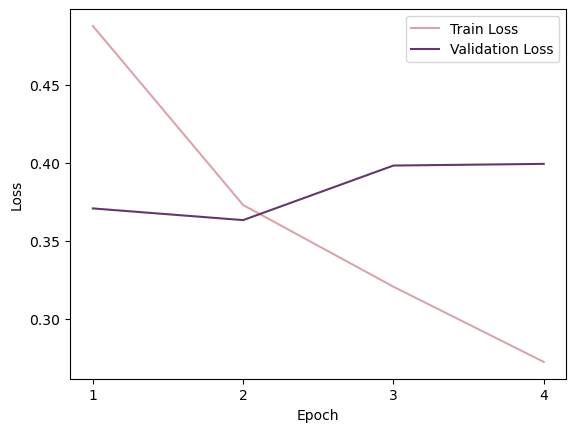

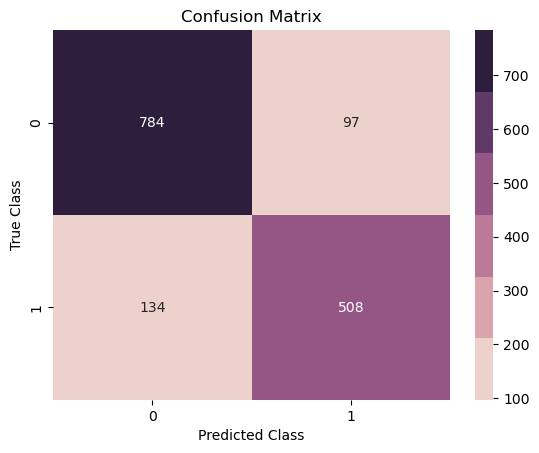

In [20]:
text_col = 'text'
target_col = 'target'
train_dataset, val_dataset, tokenizer = preprocess_train_data(train_cleaned, text_col, target_col, model_name='bert-base-uncased', tokenizer='BERT')

train_validate_test('bert-base-uncased', train_dataset, val_dataset, validation=True)

6090 training samples
1523 validation samples


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch 1 - Avg Train Loss: 0.4774 | Avg Val Loss: 0.4214
  Accuracy: 0.83
  F1 Score: 0.77
  Precision: 0.81
  Recall: 0.76
Epoch 2 - Avg Train Loss: 0.3439 | Avg Val Loss: 0.4167
  Accuracy: 0.83
  F1 Score: 0.77
  Precision: 0.84
  Recall: 0.74
Epoch 3 - Avg Train Loss: 0.2942 | Avg Val Loss: 0.5108
  Accuracy: 0.80
  F1 Score: 0.76
  Precision: 0.75
  Recall: 0.80
Epoch 4 - Avg Train Loss: 0.2450 | Avg Val Loss: 0.5462
  Accuracy: 0.81
  F1 Score: 0.76
  Precision: 0.77
  Recall: 0.78
No improvement in validation loss for 2 epochs. Stopping early.


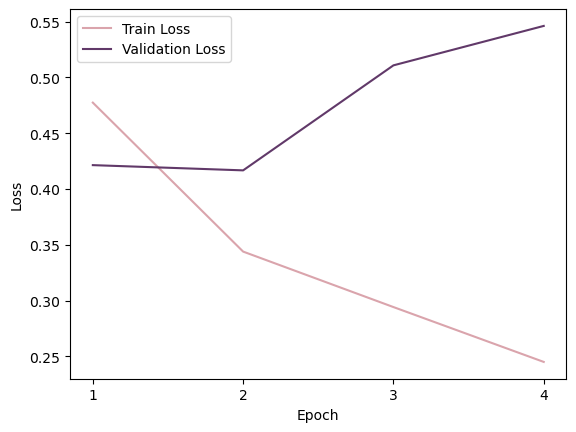

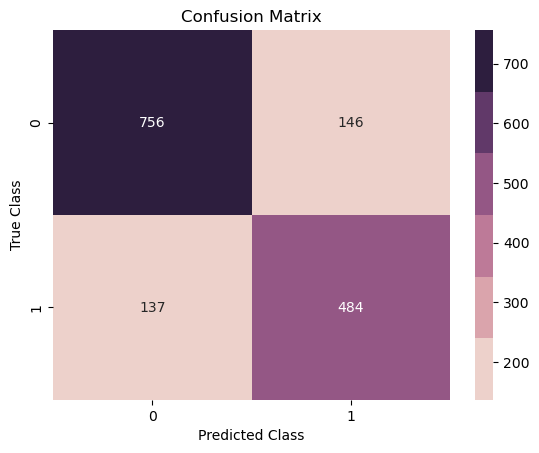

In [21]:
text_col = 'text_cleaned'
target_col = 'target'
train_dataset, val_dataset, tokenizer = preprocess_train_data(train_cleaned, text_col, target_col, model_name='bert-base-uncased', tokenizer='BERT')

train_validate_test('bert-base-uncased', train_dataset, val_dataset, validation=True)